In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.callbacks import EarlyStopping,CSVLogger
from tensorflow.keras import backend as K
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt
import numpy as np
from equation_as2 import equation

C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# add to the top of your code under import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
#import dataset
train_x = pickle.load(open('./Data/train_pairs.pickle','rb'))
train_y = pickle.load(open('./Data/train_y.pickle','rb'))
test_x1 = pickle.load(open('./Data/test_pairs1.pickle','rb'))
test_y1 = pickle.load(open('./Data/test_y1.pickle','rb'))
test_x2 = pickle.load(open('./Data/test_pairs2.pickle','rb'))
test_y2 = pickle.load(open('./Data/test_y2.pickle','rb'))
test_x3 = pickle.load(open('./Data/test_pairs3.pickle','rb'))
test_y3 = pickle.load(open('./Data/test_y3.pickle','rb'))

In [4]:
train_x = train_x.astype('float32')
test_x1 = test_x1.astype('float32')
test_x2 = test_x2.astype('float32')
test_x3 = test_x3.astype('float32')
train_x /= 255
test_x1 /= 255
test_x2 /= 255
test_x3 /= 255

In [5]:
img_rows, img_cols = train_x.shape[2:4]
train_x = train_x.reshape(train_x.shape[0], 2 ,img_rows, img_cols, 1)
test_x1 = test_x1.reshape(test_x1.shape[0],2, img_rows, img_cols, 1)
test_x2 = test_x2.reshape(test_x2.shape[0],2, img_rows, img_cols, 1)
test_x3 = test_x3.reshape(test_x3.shape[0],2, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [6]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    output = Dense(128, activation=tf.nn.relu,name = 'embeding')(x) 
    
    return Model(input_tensor, output)

In [7]:
def create_base_network_1(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [8]:
def siamese_model(input_shape,cnn_base_network):
    base_network = cnn_base_network
    base_network.summary()
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    # because we re-use the same instance `base_network`,
    # the weights of the network
    # will be shared across the two branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = Lambda(equation.euclidean_distance,
                      output_shape=equation.eucl_dist_output_shape)([processed_a, processed_b])

    model = Model([input_a, input_b], distance)
    model.summary()
    
    return model

In [9]:
def plot_loss_accuracy(history,parameter):
    print("Tuning :"+parameter)
    loss = history.history['loss'].copy()
    val_loss= history.history['val_loss'].copy()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss','Validation loss'])
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Tuning:"+parameter+" loss")
    plt.savefig('./images/'+parameter+'_loss.png', bbox_inches='tight')
    plt.show()
    plt.close()
    accuracy = history.history['accuracy'].copy()
    val_accuracy = history.history['val_accuracy'].copy()
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.legend(['accuracy','val_accuracy'])
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Tuning :"+parameter+" accuracy")
    plt.savefig('./images/'+parameter+'_accuracy.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [10]:
def evaluate_test_accuracy(model,model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3):
    print("Tuning :"+model_name)
    pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
    pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
    pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

    te_acc1 = equation.compute_accuracy(test_y1, pred1)
    te_acc2 = equation.compute_accuracy(test_y2, pred2)
    te_acc3 = equation.compute_accuracy(test_y3, pred3)
    print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
    print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
    print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

    model.save('./Data/model'+model_name+'.h5')

In [11]:
#set margin
Ass2_Equation = equation(0.7)

### Tuning Hyperparameters

In [12]:
#check fully connect layer embedding 1

In [13]:
select_base_arch=create_base_network(input_shape)
model=siamese_model(input_shape,select_base_arch)

W1013 08:11:09.875180 21488 deprecation.py:506] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          18496 

In [14]:
model_name='lr_1e-4_emb_1'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model/Model_'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

W1013 08:11:10.375987 21488 deprecation.py:323] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 145us/sample - loss: 4.7242 - accuracy: 0.5039 - val_loss: 0.2567 - val_accuracy: 0.4850
Epoch 2/200
60145/60145 [==============================] - 7s 108us/sample - loss: 0.2140 - accuracy: 0.5030 - val_loss: 0.2624 - val_accuracy: 0.4597
Epoch 3/200
60145/60145 [==============================] - 6s 108us/sample - loss: 0.1979 - accuracy: 0.5059 - val_loss: 0.2570 - val_accuracy: 0.4750
Epoch 4/200
60145/60145 [==============================] - 7s 108us/sample - loss: 0.1871 - accuracy: 0.5235 - val_loss: 0.3192 - val_accuracy: 0.5003
Epoch 5/200
60145/60145 [==============================] - 7s 108us/sample - loss: 0.1703 - accuracy: 0.5728 - val_loss: 0.2672 - val_accuracy: 0.7131
Epoch 6/200
60145/60145 [==============================] - 7s 108us/sample - loss: 0.1527 - accuracy: 0.6088 - val_loss: 0.1821 - val_accuracy: 0.6776
Epoch 7/200
60145/60145 [====================

Tuning :lr_1e-4_emb_1


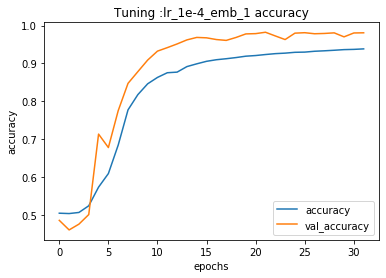

Tuning :lr_1e-4_emb_1
* Accuracy on test1 set: 92.43%
* Accuracy on test2 set: 67.29%
* Accuracy on test3 set: 80.51%


In [15]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [16]:
select_base_arch=create_base_network_1(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [17]:
model_name='lr_1e-4_emb_2'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model/Model_'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 7s 125us/sample - loss: 1.7817 - accuracy: 0.6100 - val_loss: 0.0774 - val_accuracy: 0.8292
Epoch 2/200
60145/60145 [==============================] - 7s 114us/sample - loss: 0.0720 - accuracy: 0.8080 - val_loss: 0.0490 - val_accuracy: 0.9018
Epoch 3/200
60145/60145 [==============================] - 7s 114us/sample - loss: 0.0506 - accuracy: 0.8581 - val_loss: 0.0403 - val_accuracy: 0.9274
Epoch 4/200
60145/60145 [==============================] - 7s 113us/sample - loss: 0.0422 - accuracy: 0.8838 - val_loss: 0.0343 - val_accuracy: 0.9365
Epoch 5/200
60145/60145 [==============================] - 7s 113us/sample - loss: 0.0371 - accuracy: 0.8979 - val_loss: 0.0310 - val_accuracy: 0.9458
Epoch 6/200
60145/60145 [==============================] - 7s 113us/sample - loss: 0.0337 - accuracy: 0.9092 - val_loss: 0.0280 - val_accuracy: 0.9523
Epoch 7/200
60145/60145 [====================

Tuning :lr_1e-4_emb_2


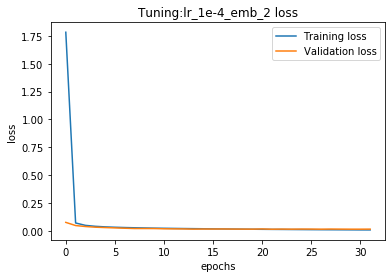

Tuning :lr_1e-4_emb_2
* Accuracy on test1 set: 95.45%
* Accuracy on test2 set: 69.97%
* Accuracy on test3 set: 82.47%


In [18]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [19]:
#drop out

In [20]:
def create_base_network_drop(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [21]:
select_base_arch=create_base_network_drop(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [22]:
model_name='relu_lr1e-4_dropout'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 130us/sample - loss: 3.1139 - accuracy: 0.5166 - val_loss: 0.2051 - val_accuracy: 0.5104
Epoch 2/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.2085 - accuracy: 0.5095 - val_loss: 0.2043 - val_accuracy: 0.4769
Epoch 3/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.1825 - accuracy: 0.5256 - val_loss: 0.1370 - val_accuracy: 0.6325
Epoch 4/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.1250 - accuracy: 0.6486 - val_loss: 0.0968 - val_accuracy: 0.7575
Epoch 5/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.0859 - accuracy: 0.7420 - val_loss: 0.0510 - val_accuracy: 0.9151
Epoch 6/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0728 - accuracy: 0.7766 - val_loss: 0.0348 - val_accuracy: 0.9446
Epoch 7/200
60145/60145 [====================

Tuning :relu_lr1e-4_dropout


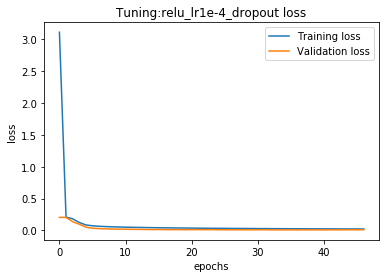

Tuning :relu_lr1e-4_dropout
* Accuracy on test1 set: 92.46%
* Accuracy on test2 set: 65.22%
* Accuracy on test3 set: 79.81%


In [23]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [24]:
def create_base_network_drop_2(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation=tf.nn.relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [25]:
select_base_arch=create_base_network_drop_2(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [26]:
model_name='relu_lr1e-4_dropout_after_flat'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 130us/sample - loss: 3.1523 - accuracy: 0.5015 - val_loss: 0.2179 - val_accuracy: 0.5147
Epoch 2/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.2067 - accuracy: 0.5092 - val_loss: 0.2174 - val_accuracy: 0.4984
Epoch 3/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.1857 - accuracy: 0.5260 - val_loss: 0.1165 - val_accuracy: 0.7290
Epoch 4/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.1584 - accuracy: 0.5782 - val_loss: 0.0551 - val_accuracy: 0.8967
Epoch 5/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.1037 - accuracy: 0.7000 - val_loss: 0.0405 - val_accuracy: 0.8947
Epoch 6/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.0721 - accuracy: 0.7768 - val_loss: 0.0396 - val_accuracy: 0.9011
Epoch 7/200
60145/60145 [====================

Epoch 108/200
60145/60145 [==============================] - 514s 9ms/sample - loss: 0.0119 - accuracy: 0.9640 - val_loss: 0.0166 - val_accuracy: 0.9810
Epoch 109/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.0116 - accuracy: 0.9652 - val_loss: 0.0150 - val_accuracy: 0.9828
Epoch 110/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0116 - accuracy: 0.9650 - val_loss: 0.0161 - val_accuracy: 0.9833
Epoch 111/200
60145/60145 [==============================] - 7s 115us/sample - loss: 0.0115 - accuracy: 0.9654 - val_loss: 0.0159 - val_accuracy: 0.9795


Tuning :relu_lr1e-4_dropout_after_flat


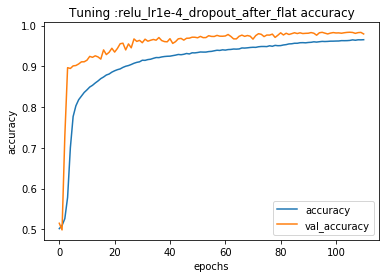

Tuning :relu_lr1e-4_dropout_after_flat
* Accuracy on test1 set: 94.51%
* Accuracy on test2 set: 68.62%
* Accuracy on test3 set: 81.63%


In [27]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [28]:
def create_base_network_drop_3(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.relu,name = 'embeding')(x) 
    x = Dropout(0.2)(x)
    output = Dense(128, activation=tf.nn.relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [29]:
select_base_arch=create_base_network_drop_3(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [30]:
model_name='relu_lr1e-4_dropout_3'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 133us/sample - loss: 2.6123 - accuracy: 0.5005 - val_loss: 0.2052 - val_accuracy: 0.4726
Epoch 2/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.1967 - accuracy: 0.5106 - val_loss: 0.2090 - val_accuracy: 0.4543
Epoch 3/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.1775 - accuracy: 0.5151 - val_loss: 0.2023 - val_accuracy: 0.4479
Epoch 4/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.1599 - accuracy: 0.5251 - val_loss: 0.1707 - val_accuracy: 0.4848
Epoch 5/200
60145/60145 [==============================] - 7s 118us/sample - loss: 0.1400 - accuracy: 0.5571 - val_loss: 0.1353 - val_accuracy: 0.5364
Epoch 6/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.1215 - accuracy: 0.5911 - val_loss: 0.1086 - val_accuracy: 0.5716
Epoch 7/200
60145/60145 [====================

Tuning :relu_lr1e-4_dropout_3


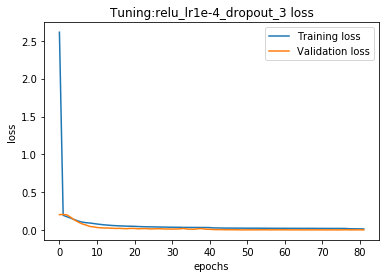

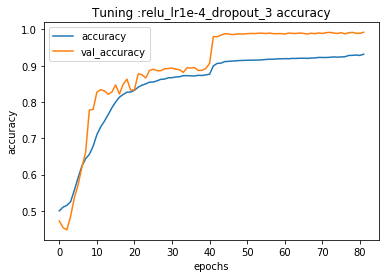

Tuning :relu_lr1e-4_dropout_3
* Accuracy on test1 set: 91.81%
* Accuracy on test2 set: 65.01%
* Accuracy on test3 set: 79.09%


In [31]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [32]:
##CHECK MARGIN

Learning rate

In [45]:
select_base_arch=create_base_network_drop_2(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_18 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [46]:
model_name='lr_1e-4'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15)
csv_logger = CSVLogger('./Data/Model/Model_'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 139us/sample - loss: 2.6292 - accuracy: 0.5076 - val_loss: 0.2213 - val_accuracy: 0.5090
Epoch 2/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.2070 - accuracy: 0.5066 - val_loss: 0.1972 - val_accuracy: 0.4820
Epoch 3/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.1423 - accuracy: 0.5946 - val_loss: 0.0953 - val_accuracy: 0.7132
Epoch 4/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.1003 - accuracy: 0.6835 - val_loss: 0.0914 - val_accuracy: 0.7379
Epoch 5/200
60145/60145 [==============================] - 7s 119us/sample - loss: 0.0902 - accuracy: 0.7113 - val_loss: 0.0904 - val_accuracy: 0.7581
Epoch 6/200
60145/60145 [==============================] - 7s 119us/sample - loss: 0.0853 - accuracy: 0.7255 - val_loss: 0.0831 - val_accuracy: 0.7847
Epoch 7/200
60145/60145 [====================

Tuning :lr_1e-4


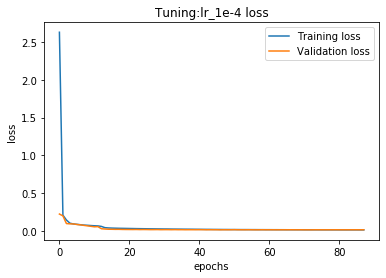

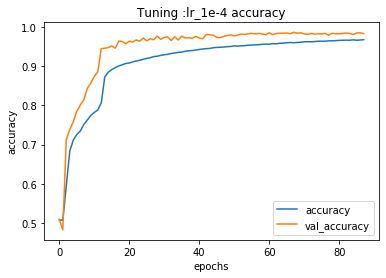

Tuning :lr_1e-4
* Accuracy on test1 set: 95.04%
* Accuracy on test2 set: 70.33%
* Accuracy on test3 set: 82.66%


In [47]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [48]:
select_base_arch=create_base_network_drop_2(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_20 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [49]:
model_name='lr1e-3'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 141us/sample - loss: 0.3634 - accuracy: 0.7377 - val_loss: 0.0253 - val_accuracy: 0.9166
Epoch 2/200
60145/60145 [==============================] - 7s 123us/sample - loss: 0.0437 - accuracy: 0.8598 - val_loss: 0.0198 - val_accuracy: 0.9430
Epoch 3/200
60145/60145 [==============================] - 7s 125us/sample - loss: 0.0381 - accuracy: 0.8805 - val_loss: 0.0183 - val_accuracy: 0.9458
Epoch 4/200
60145/60145 [==============================] - 7s 123us/sample - loss: 0.0344 - accuracy: 0.8932 - val_loss: 0.0174 - val_accuracy: 0.9437
Epoch 5/200
60145/60145 [==============================] - 7s 124us/sample - loss: 0.0319 - accuracy: 0.9048 - val_loss: 0.0164 - val_accuracy: 0.9673
Epoch 6/200
60145/60145 [==============================] - 7s 123us/sample - loss: 0.0292 - accuracy: 0.9158 - val_loss: 0.0153 - val_accuracy: 0.9709
Epoch 7/200
60145/60145 [====================

Tuning :lr1e-3


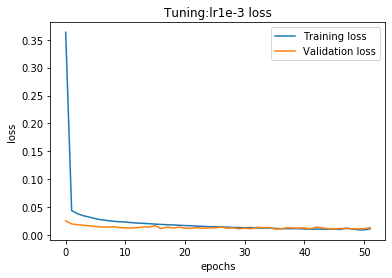

In [50]:
plot_loss_accuracy(history, model_name)

In [51]:
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

Tuning :lr1e-3
* Accuracy on test1 set: 95.11%
* Accuracy on test2 set: 67.77%
* Accuracy on test3 set: 81.60%


In [52]:
select_base_arch=create_base_network_drop_2(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_22 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [53]:
model_name='lr3e-3'
# train
epochs = 200
adam = Adam(learning_rate=3e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 144us/sample - loss: 0.2623 - accuracy: 0.7685 - val_loss: 0.0179 - val_accuracy: 0.9726
Epoch 2/200
60145/60145 [==============================] - 7s 121us/sample - loss: 0.0403 - accuracy: 0.8738 - val_loss: 0.0144 - val_accuracy: 0.9832
Epoch 3/200
60145/60145 [==============================] - 7s 119us/sample - loss: 0.0345 - accuracy: 0.8919 - val_loss: 0.0094 - val_accuracy: 0.9861
Epoch 4/200
60145/60145 [==============================] - 7s 119us/sample - loss: 0.0315 - accuracy: 0.9008 - val_loss: 0.0071 - val_accuracy: 0.9901
Epoch 5/200
60145/60145 [==============================] - 7s 119us/sample - loss: 0.0300 - accuracy: 0.9053 - val_loss: 0.0065 - val_accuracy: 0.9886
Epoch 6/200
60145/60145 [==============================] - 7s 119us/sample - loss: 0.0287 - accuracy: 0.9076 - val_loss: 0.0053 - val_accuracy: 0.9912
Epoch 7/200
60145/60145 [====================

Tuning :lr3e-3


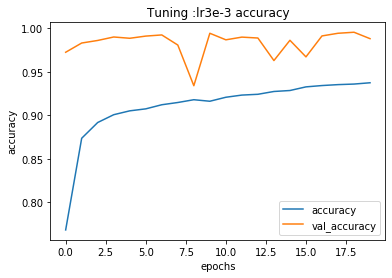

Tuning :lr3e-3
* Accuracy on test1 set: 92.57%
* Accuracy on test2 set: 69.94%
* Accuracy on test3 set: 80.96%


In [54]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [55]:
select_base_arch=create_base_network_drop_2(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_24 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [56]:
model_name='lr1e+3'
# train
epochs = 200
adam = Adam(learning_rate=1e+3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 141us/sample - loss: 0.3778 - accuracy: 0.4997 - val_loss: 0.2448 - val_accuracy: 0.5008
Epoch 2/200
60145/60145 [==============================] - 7s 120us/sample - loss: 61082134024282488832.0000 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.5008
Epoch 3/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.4997
Epoch 4/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.4985
Epoch 5/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.5008
Epoch 6/200
60145/60145 [==============================] - 7s 120us/sample - loss: 0.2448 - accuracy: 0.5000 - val_loss: 0.2448 - val_accuracy: 0.4991
Epoch 7/200
60145/60145 [=

Tuning :lr1e+3


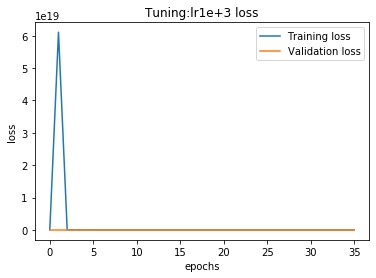

Tuning :lr1e+3
* Accuracy on test1 set: 50.00%
* Accuracy on test2 set: 50.00%
* Accuracy on test3 set: 50.00%


In [57]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

leaky_RELU

In [58]:
def create_base_network_leaky_relu(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [59]:
select_base_arch=create_base_network_leaky_relu(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_26 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [60]:
model_name='leaky_relu_lr1e-4'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 153us/sample - loss: 4.2168 - accuracy: 0.5002 - val_loss: 0.1711 - val_accuracy: 0.6645
Epoch 2/200
60145/60145 [==============================] - 8s 130us/sample - loss: 0.3375 - accuracy: 0.5087 - val_loss: 0.1092 - val_accuracy: 0.6356
Epoch 3/200
60145/60145 [==============================] - 8s 130us/sample - loss: 0.2271 - accuracy: 0.5296 - val_loss: 0.0968 - val_accuracy: 0.5768
Epoch 4/200
60145/60145 [==============================] - 8s 130us/sample - loss: 0.1793 - accuracy: 0.5608 - val_loss: 0.0888 - val_accuracy: 0.5626
Epoch 5/200
60145/60145 [==============================] - 8s 130us/sample - loss: 0.1547 - accuracy: 0.6049 - val_loss: 0.0702 - val_accuracy: 0.6676
Epoch 6/200
60145/60145 [==============================] - 8s 130us/sample - loss: 0.1389 - accuracy: 0.6639 - val_loss: 0.0582 - val_accuracy: 0.7705
Epoch 7/200
60145/60145 [====================

Epoch 108/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.0126 - accuracy: 0.9676 - val_loss: 0.0072 - val_accuracy: 0.9907
Epoch 109/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.0126 - accuracy: 0.9674 - val_loss: 0.0060 - val_accuracy: 0.9919
Epoch 110/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.0123 - accuracy: 0.9680 - val_loss: 0.0062 - val_accuracy: 0.9919
Epoch 111/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.0122 - accuracy: 0.9689 - val_loss: 0.0075 - val_accuracy: 0.9895
Epoch 112/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.0121 - accuracy: 0.9686 - val_loss: 0.0065 - val_accuracy: 0.9906
Epoch 113/200
60145/60145 [==============================] - 8s 127us/sample - loss: 0.0121 - accuracy: 0.9691 - val_loss: 0.0069 - val_accuracy: 0.9915
Epoch 114/200
60145/60145 [==============================] - 8s 127us/sample - los

Tuning :leaky_relu_lr1e-4


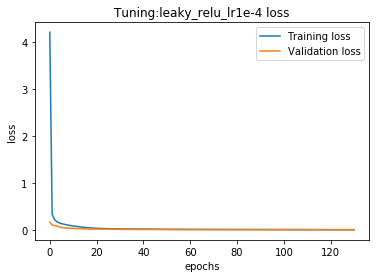

Tuning :leaky_relu_lr1e-4
* Accuracy on test1 set: 96.48%
* Accuracy on test2 set: 67.89%
* Accuracy on test3 set: 82.58%


In [61]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [62]:
select_base_arch=create_base_network_leaky_relu(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_28 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [63]:
model_name='leaky_relu_lr1e-3'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 150us/sample - loss: 0.5756 - accuracy: 0.6333 - val_loss: 0.0482 - val_accuracy: 0.8775
Epoch 2/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.0971 - accuracy: 0.8068 - val_loss: 0.0381 - val_accuracy: 0.8893
Epoch 3/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.0757 - accuracy: 0.8574 - val_loss: 0.0324 - val_accuracy: 0.8934
Epoch 4/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.0619 - accuracy: 0.8774 - val_loss: 0.0274 - val_accuracy: 0.8946
Epoch 5/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.0523 - accuracy: 0.8916 - val_loss: 0.0236 - val_accuracy: 0.9159
Epoch 6/200
60145/60145 [==============================] - 8s 128us/sample - loss: 0.0455 - accuracy: 0.9018 - val_loss: 0.0212 - val_accuracy: 0.9265
Epoch 7/200
60145/60145 [====================

Tuning :leaky_relu_lr1e-3


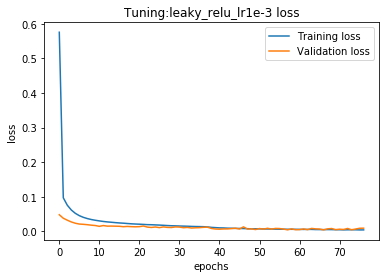

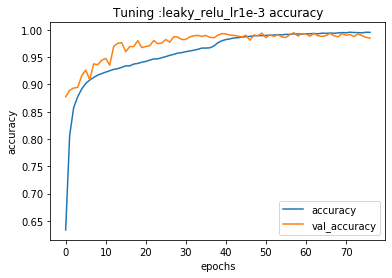

Tuning :leaky_relu_lr1e-3
* Accuracy on test1 set: 96.74%
* Accuracy on test2 set: 65.23%
* Accuracy on test3 set: 82.04%


In [64]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [65]:
#ELU

In [66]:
def create_base_network_elu(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.elu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.elu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.elu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.elu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation=tf.nn.elu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.elu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [67]:
select_base_arch=create_base_network_elu(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_30 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [68]:
model_name='ELU_lr1e-4'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 140us/sample - loss: 5.9428 - accuracy: 0.5001 - val_loss: 0.2079 - val_accuracy: 0.5361
Epoch 2/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.4025 - accuracy: 0.5084 - val_loss: 0.1252 - val_accuracy: 0.5185
Epoch 3/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.1802 - accuracy: 0.5702 - val_loss: 0.0534 - val_accuracy: 0.8664
Epoch 4/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.1079 - accuracy: 0.7314 - val_loss: 0.0413 - val_accuracy: 0.8908
Epoch 5/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.0787 - accuracy: 0.8027 - val_loss: 0.0360 - val_accuracy: 0.8949
Epoch 6/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0643 - accuracy: 0.8277 - val_loss: 0.0332 - val_accuracy: 0.8962
Epoch 7/200
60145/60145 [====================

Tuning :ELU_lr1e-4


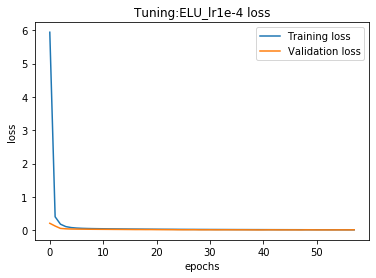

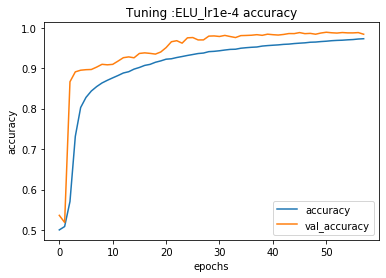

Tuning :ELU_lr1e-4
* Accuracy on test1 set: 95.89%
* Accuracy on test2 set: 69.18%
* Accuracy on test3 set: 83.33%


In [69]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [70]:
select_base_arch=create_base_network_elu(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_32 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [71]:
model_name='ELU_lr1e-3'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 141us/sample - loss: 0.6556 - accuracy: 0.7435 - val_loss: 0.0263 - val_accuracy: 0.9086
Epoch 2/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.0432 - accuracy: 0.8703 - val_loss: 0.0202 - val_accuracy: 0.9586
Epoch 3/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0360 - accuracy: 0.9000 - val_loss: 0.0169 - val_accuracy: 0.9757
Epoch 4/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0322 - accuracy: 0.9120 - val_loss: 0.0146 - val_accuracy: 0.9657
Epoch 5/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0292 - accuracy: 0.9213 - val_loss: 0.0116 - val_accuracy: 0.9830
Epoch 6/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0272 - accuracy: 0.9267 - val_loss: 0.0077 - val_accuracy: 0.9888
Epoch 7/200
60145/60145 [====================

Tuning :ELU_lr1e-3


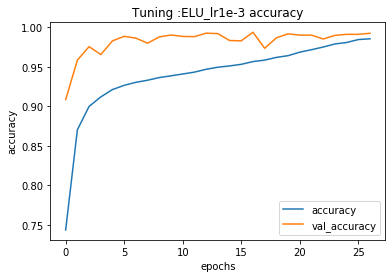

Tuning :ELU_lr1e-3
* Accuracy on test1 set: 97.08%
* Accuracy on test2 set: 64.87%
* Accuracy on test3 set: 82.01%


In [72]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [73]:
def create_base_network_leaky_relu_no_drop(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding')(x) 
    output = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [74]:
select_base_arch=create_base_network_leaky_relu_no_drop(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_34 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          184

In [75]:
model_name='leaky_relu_no_drop_lr1e-3'
# train
epochs = 200
adam = Adam(learning_rate=1e-3,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 156us/sample - loss: 0.3113 - accuracy: 0.8115 - val_loss: 0.0411 - val_accuracy: 0.9038
Epoch 2/200
60145/60145 [==============================] - 8s 132us/sample - loss: 0.0440 - accuracy: 0.8911 - val_loss: 0.0310 - val_accuracy: 0.9255
Epoch 3/200
60145/60145 [==============================] - 8s 132us/sample - loss: 0.0377 - accuracy: 0.9064 - val_loss: 0.0272 - val_accuracy: 0.9639
Epoch 4/200
60145/60145 [==============================] - 8s 132us/sample - loss: 0.0348 - accuracy: 0.9152 - val_loss: 0.0225 - val_accuracy: 0.9590
Epoch 5/200
60145/60145 [==============================] - 8s 132us/sample - loss: 0.0322 - accuracy: 0.9220 - val_loss: 0.0191 - val_accuracy: 0.9661
Epoch 6/200
60145/60145 [==============================] - 8s 131us/sample - loss: 0.0302 - accuracy: 0.9252 - val_loss: 0.0187 - val_accuracy: 0.9763
Epoch 7/200
60145/60145 [====================

Tuning :leaky_relu_no_drop_lr1e-3


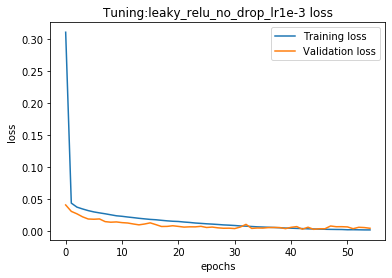

Tuning :leaky_relu_no_drop_lr1e-3
* Accuracy on test1 set: 96.99%
* Accuracy on test2 set: 66.37%
* Accuracy on test3 set: 82.75%


In [76]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [ ]:
#embeding 64

In [16]:
def create_base_network_elu(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.elu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.elu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.elu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.elu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation=tf.nn.elu,name = 'embeding')(x) 
    output = Dense(64, activation=tf.nn.elu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [17]:
select_base_arch=create_base_network_elu(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [18]:
model_name='ELU_lr1e-4_emb_64'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

W1013 16:02:58.795281  3488 deprecation.py:323] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 10s 167us/sample - loss: 2.5303 - accuracy: 0.5213 - val_loss: 0.0770 - val_accuracy: 0.7974
Epoch 2/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.1407 - accuracy: 0.6437 - val_loss: 0.0683 - val_accuracy: 0.7149
Epoch 3/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.1022 - accuracy: 0.7114 - val_loss: 0.0453 - val_accuracy: 0.8714
Epoch 4/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.0813 - accuracy: 0.7740 - val_loss: 0.0439 - val_accuracy: 0.8825
Epoch 5/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.0709 - accuracy: 0.7961 - val_loss: 0.0440 - val_accuracy: 0.8845
Epoch 6/200
60145/60145 [==============================] - 7s 111us/sample - loss: 0.0637 - accuracy: 0.8123 - val_loss: 0.0437 - val_accuracy: 0.8862
Epoch 7/200
60145/60145 [===================

60145/60145 [==============================] - 7s 109us/sample - loss: 0.0167 - accuracy: 0.9545 - val_loss: 0.0130 - val_accuracy: 0.9849
Epoch 55/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.0161 - accuracy: 0.9559 - val_loss: 0.0111 - val_accuracy: 0.9842
Epoch 56/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.0158 - accuracy: 0.9570 - val_loss: 0.0100 - val_accuracy: 0.9873
Epoch 57/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.0155 - accuracy: 0.9573 - val_loss: 0.0100 - val_accuracy: 0.9844
Epoch 58/200
60145/60145 [==============================] - 7s 112us/sample - loss: 0.0151 - accuracy: 0.9589 - val_loss: 0.0101 - val_accuracy: 0.9856
Epoch 59/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.0148 - accuracy: 0.9602 - val_loss: 0.0095 - val_accuracy: 0.9870
Epoch 60/200
60145/60145 [==============================] - 7s 112us/sample - loss: 0.0146 - accuracy

In [19]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

Tuning :ELU_lr1e-4_emb_64


Tuning :ELU_lr1e-4_emb_64
* Accuracy on test1 set: 95.88%
* Accuracy on test2 set: 69.89%
* Accuracy on test3 set: 82.95%


In [21]:
#256

In [22]:
def create_base_network_elu_emb_256(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.elu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.elu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.elu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.elu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation=tf.nn.elu,name = 'embeding')(x) 
    output = Dense(256, activation=tf.nn.elu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [23]:
select_base_arch=create_base_network_elu_emb_256(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [24]:
model_name='ELU_lr1e-4_emb_256'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 7s 123us/sample - loss: 8.2319 - accuracy: 0.5065 - val_loss: 0.1129 - val_accuracy: 0.6105
Epoch 2/200
60145/60145 [==============================] - 7s 111us/sample - loss: 0.1598 - accuracy: 0.6078 - val_loss: 0.0511 - val_accuracy: 0.8814
Epoch 3/200
60145/60145 [==============================] - 7s 112us/sample - loss: 0.0922 - accuracy: 0.7440 - val_loss: 0.0420 - val_accuracy: 0.8939
Epoch 4/200
60145/60145 [==============================] - 7s 114us/sample - loss: 0.0725 - accuracy: 0.7889 - val_loss: 0.0379 - val_accuracy: 0.8946
Epoch 5/200
60145/60145 [==============================] - 7s 114us/sample - loss: 0.0638 - accuracy: 0.8056 - val_loss: 0.0354 - val_accuracy: 0.8978
Epoch 6/200
60145/60145 [==============================] - 7s 111us/sample - loss: 0.0577 - accuracy: 0.8166 - val_loss: 0.0325 - val_accuracy: 0.9104
Epoch 7/200
60145/60145 [====================

60145/60145 [==============================] - 7s 112us/sample - loss: 0.0074 - accuracy: 0.9838 - val_loss: 0.0121 - val_accuracy: 0.9853
Epoch 55/200
60145/60145 [==============================] - 7s 112us/sample - loss: 0.0072 - accuracy: 0.9846 - val_loss: 0.0118 - val_accuracy: 0.9853
Epoch 56/200
60145/60145 [==============================] - 7s 112us/sample - loss: 0.0069 - accuracy: 0.9865 - val_loss: 0.0112 - val_accuracy: 0.9872
Epoch 57/200
60145/60145 [==============================] - 7s 112us/sample - loss: 0.0068 - accuracy: 0.9862 - val_loss: 0.0119 - val_accuracy: 0.9852
Epoch 58/200
60145/60145 [==============================] - 7s 112us/sample - loss: 0.0067 - accuracy: 0.9862 - val_loss: 0.0106 - val_accuracy: 0.9866
Epoch 59/200
60145/60145 [==============================] - 7s 112us/sample - loss: 0.0065 - accuracy: 0.9878 - val_loss: 0.0112 - val_accuracy: 0.9868
Epoch 60/200
60145/60145 [==============================] - 7s 113us/sample - loss: 0.0061 - accuracy

Tuning :ELU_lr1e-4_emb_256


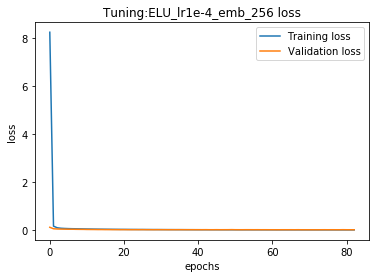

Tuning :ELU_lr1e-4_emb_256
* Accuracy on test1 set: 96.85%
* Accuracy on test2 set: 69.56%
* Accuracy on test3 set: 83.58%


In [25]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [26]:
#512

In [27]:
def create_base_network_elu_emb_256(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.elu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.elu,name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.elu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.elu,name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation=tf.nn.elu,name = 'embeding')(x) 
    output = Dense(512, activation=tf.nn.elu,name = 'embeding2')(x) 
    
    return Model(input_tensor, output)

In [28]:
select_base_arch=create_base_network_elu_emb_256(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [29]:
model_name='ELU_lr1e-4_emb_512'
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model'+model_name+'.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 8s 127us/sample - loss: 9.5508 - accuracy: 0.5243 - val_loss: 0.1113 - val_accuracy: 0.5150
Epoch 2/200
60145/60145 [==============================] - 7s 115us/sample - loss: 0.1215 - accuracy: 0.5545 - val_loss: 0.0838 - val_accuracy: 0.5879
Epoch 3/200
60145/60145 [==============================] - 7s 114us/sample - loss: 0.0976 - accuracy: 0.6566 - val_loss: 0.0659 - val_accuracy: 0.7470
Epoch 4/200
60145/60145 [==============================] - 7s 116us/sample - loss: 0.0846 - accuracy: 0.7093 - val_loss: 0.0526 - val_accuracy: 0.7975
Epoch 5/200
60145/60145 [==============================] - 7s 117us/sample - loss: 0.0736 - accuracy: 0.7477 - val_loss: 0.0446 - val_accuracy: 0.8306
Epoch 6/200
60145/60145 [==============================] - 7s 115us/sample - loss: 0.0648 - accuracy: 0.7827 - val_loss: 0.0419 - val_accuracy: 0.8574
Epoch 7/200
60145/60145 [====================

60145/60145 [==============================] - 7s 114us/sample - loss: 0.0060 - accuracy: 0.9893 - val_loss: 0.0090 - val_accuracy: 0.9895


In [30]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

Tuning :ELU_lr1e-4_emb_512


Tuning :ELU_lr1e-4_emb_512
* Accuracy on test1 set: 96.76%
* Accuracy on test2 set: 66.60%
* Accuracy on test3 set: 82.55%
